In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [2]:
def cal_value(df):

    # 计算收益、回撤和夏普
    r = df['pred1收益率'].tolist()
    N = len(r)
    value = np.zeros(N+1)
    value[0] = 1.0
    for t in range(1, N+1):
        value[t] = value[t-1] * (r[t-1])

    cumulative_return = value[-1] - 1

     # 计算收益、回撤和夏普
    r300 = df['hs300收益率'].tolist()
    N = len(r300)
    value_hs300 = np.zeros(N+1)
    value_hs300[0] = 1.0
    for t in range(1, N+1):
        value_hs300[t] = value_hs300[t-1] * (r300[t-1])

    cumulative_return_e = cumulative_return - value_hs300[-1]
    
    peak = 1.0
    max_drawdown = 0.0
    for t in range(1, N+1):
        if value[t] > peak:
            peak = value[t]
        else:
            drawdown = (peak - value[t]) / peak
            max_drawdown = max(max_drawdown, drawdown)
    
    daily_returns = df['超额收益']
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252) if np.std(daily_returns) != 0 else 0

    print(f"超额收益: {cumulative_return_e:.4f}")
    print(f"累计收益: {cumulative_return:.4f}")
    print(f"最大回撤: {max_drawdown:.4f}")
    print(f"夏普比率: {sharpe_ratio:.4f}")

In [3]:
def plot_value(df, strategy):
    # 绘制曲线图
    value_date = df['交易日期'].tolist()
    value_date = [pd.to_datetime('2021-01-03')] + value_date
    # 计算收益、回撤和夏普
    r = df['pred1收益率'].tolist()
    N = len(r)
    value = np.zeros(N+1)
    value[0] = 1.0
    for t in range(1, N+1):
        value[t] = value[t-1] * (r[t-1])

    # 计算收益、回撤和夏普
    r300 = df['hs300收益率'].tolist()
    N = len(r300)
    value_hs300 = np.zeros(N+1)
    value_hs300[0] = 1.0
    for t in range(1, N+1):
        value_hs300[t] = value_hs300[t-1] * (r300[t-1])
    plt.figure(figsize=(20, 10))         # 设置图像大小
    plt.plot(value_date, value, label=strategy, color='blue', linestyle='-', linewidth=2)
    plt.plot(value_date, value_hs300, label='hs300', color='red', linestyle='-', linewidth=2)
    
    # 添加标题和标签
    plt.title('净值曲线', fontsize=14)
    plt.xlabel('时间', fontsize=12)
    plt.ylabel('净值', fontsize=12)
    
    # 添加图例和网格
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # 显示图像
    plt.show()

## 读取数据

In [5]:
df_hs300 = pd.read_csv("01_data/hs300.csv")
df_hs300["交易日期"] = pd.to_datetime(df_hs300["交易日期"])
df_hs300_c_s = pd.read_csv("01_data/hs300_constituent_stocks.csv")
df_hs300_c_s["交易日期"] = pd.to_datetime(df_hs300_c_s["交易日期"])
df_hs300_c_s_p = pd.read_csv("01_data/hs300_constituent_stocks_predict.csv")
df_hs300_c_s_p = df_hs300_c_s_p.rename(columns={'date': '交易日期','code': '股票代码'})
df_hs300_c_s_p["交易日期"] = pd.to_datetime(df_hs300_c_s_p["交易日期"])

## 合并真实值与预测

In [7]:
df_hs300_c_s_p_merge = pd.merge(df_hs300_c_s, df_hs300_c_s_p, on = ["交易日期", "股票代码"], how = "inner")

## 策略与评估

### 1 全仓购买预测值排序为1的股票

In [10]:
# 先按股票代码排序，方便获取预测值第一的股票下一天的收益
df_hs300_c_s_p_merge_new = df_hs300_c_s_p_merge.sort_values(by = ['股票代码','交易日期'],ascending=True)

In [11]:
# 获取预测值第一的股票下一天的收益
df_hs300_c_s_p1_rate = df_hs300_c_s_p_merge_new[df_hs300_c_s_p_merge_new['pred'].shift(1) == 1.0].sort_values(by = ['交易日期'],ascending=True)[['交易日期','涨跌幅（%）']]
df_hs300_c_s_p1_rate['pred1收益率'] = df_hs300_c_s_p1_rate['涨跌幅（%）'] + 1

In [106]:
df_hs300_c_s_p1_rate

,交易日期,涨跌幅（%）,pred1收益率,涨跌幅(%),hs300收益率,超额收益
0,2021-01-04,0.004464,1.004464,1.08,1.0108,-0.006336
1,2021-01-05,0.100204,1.100204,1.91,1.0191,0.081104
2,2021-01-06,0.100372,1.100372,0.92,1.0092,0.091172
3,2021-01-07,0.042445,1.042445,1.77,1.0177,0.024745
4,2021-01-08,0.000000,1.000000,-0.33,0.9967,0.003300
...,...,...,...,...,...,...
722,2023-12-25,0.007042,1.007042,0.31,1.0031,0.003942
723,2023-12-26,0.002732,1.002732,-0.68,0.9932,0.009532
724,2023-12-27,0.005450,1.005450,0.35,1.0035,0.001950
725,2023-12-28,-0.016260,0.983740,2.34,1.0234,-0.039660


In [12]:
# 获取沪深300涨跌幅
df_hs300_rate = df_hs300[pd.to_datetime('2021-01-04') <= df_hs300["交易日期"]][['交易日期','涨跌幅(%)']]
df_hs300_rate['hs300收益率'] = df_hs300_rate['涨跌幅(%)']/100 + 1

In [13]:
# 计算选取的超额收益
df_hs300_c_s_p1_rate = pd.merge(df_hs300_c_s_p1_rate, df_hs300_rate, on = ["交易日期"], how = "inner")
df_hs300_c_s_p1_rate['超额收益'] = df_hs300_c_s_p1_rate['pred1收益率'] - df_hs300_c_s_p1_rate['hs300收益率']

In [14]:
# 计算收益、回撤和夏普
cal_value(df_hs300_c_s_p1_rate)

超额收益: 91.5145
累计收益: 92.1741
最大回撤: 0.2277
夏普比率: 3.9609


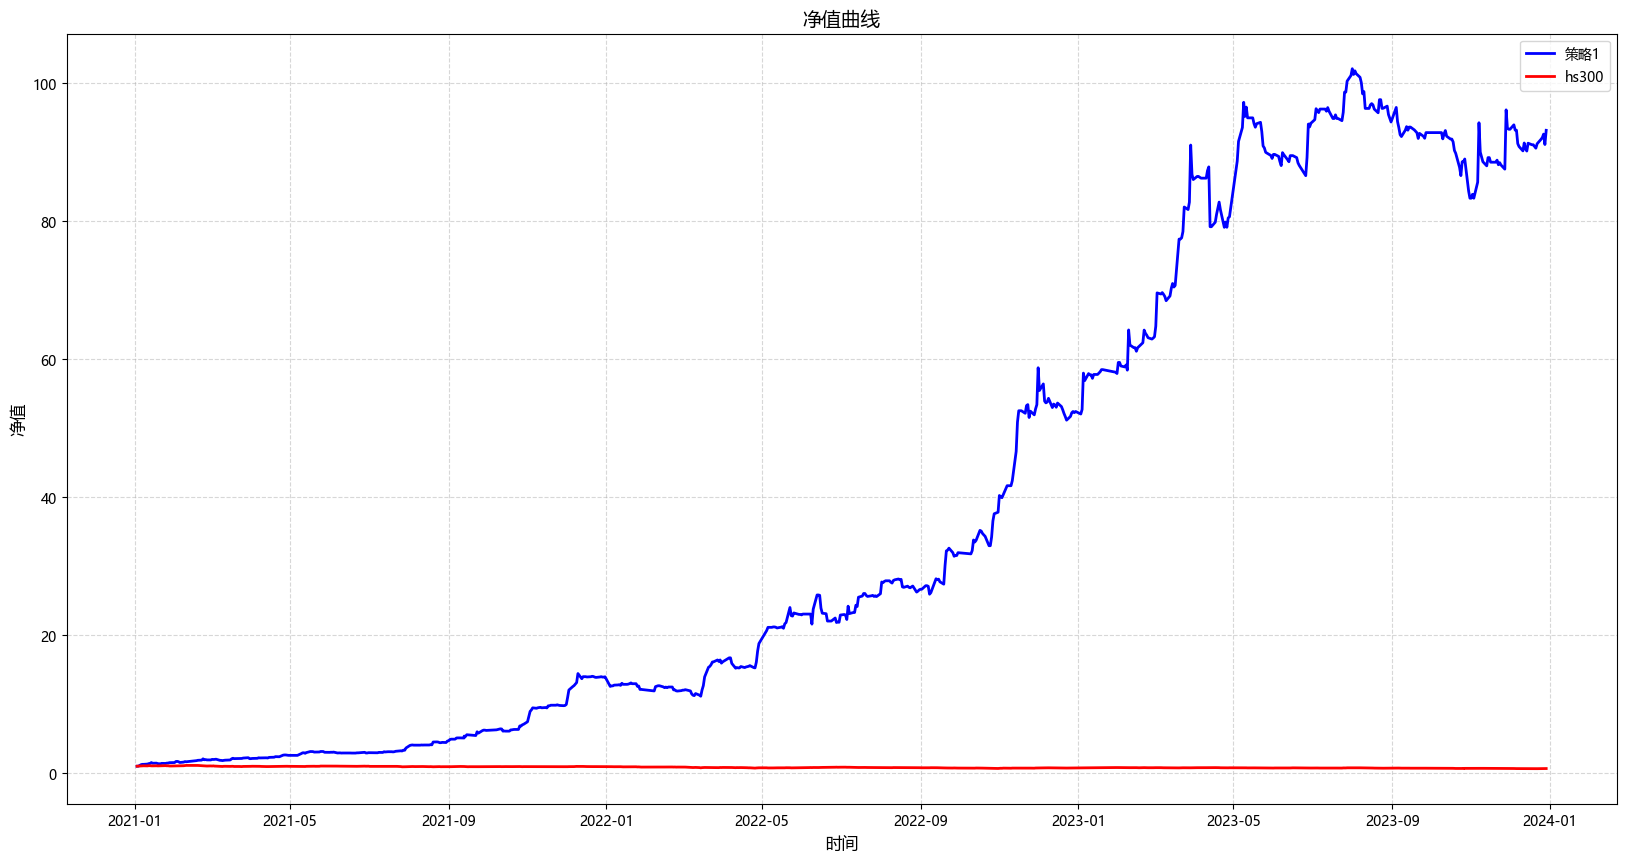

In [15]:
plot_value(df_hs300_c_s_p1_rate, '策略1')

### 2 购买预测值排序为1和2的股票各50%

In [17]:
# 获取预测值第一的股票下一天的收益
df_hs300_c_s_p1and2_rate = df_hs300_c_s_p_merge_new[df_hs300_c_s_p_merge_new['pred'].shift(1) <= 2.0].sort_values(by = ['交易日期'],ascending=True)[['交易日期','涨跌幅（%）']]
df_hs300_c_s_p1and2_rate = pd.DataFrame(df_hs300_c_s_p1and2_rate.groupby('交易日期')['涨跌幅（%）'].mean() + 1)
df_hs300_c_s_p1and2_rate.columns = ['pred1收益率']
df_hs300_c_s_p1and2_rate = pd.merge(df_hs300_c_s_p1and2_rate, df_hs300_rate, on = ["交易日期"], how = "inner")
df_hs300_c_s_p1and2_rate['超额收益'] = df_hs300_c_s_p1and2_rate['pred1收益率'] - df_hs300_c_s_p1and2_rate['hs300收益率']

In [18]:
# 计算收益、回撤和夏普
cal_value(df_hs300_c_s_p1and2_rate)

超额收益: 52.6528
累计收益: 53.3120
最大回撤: 0.1240
夏普比率: 4.9538


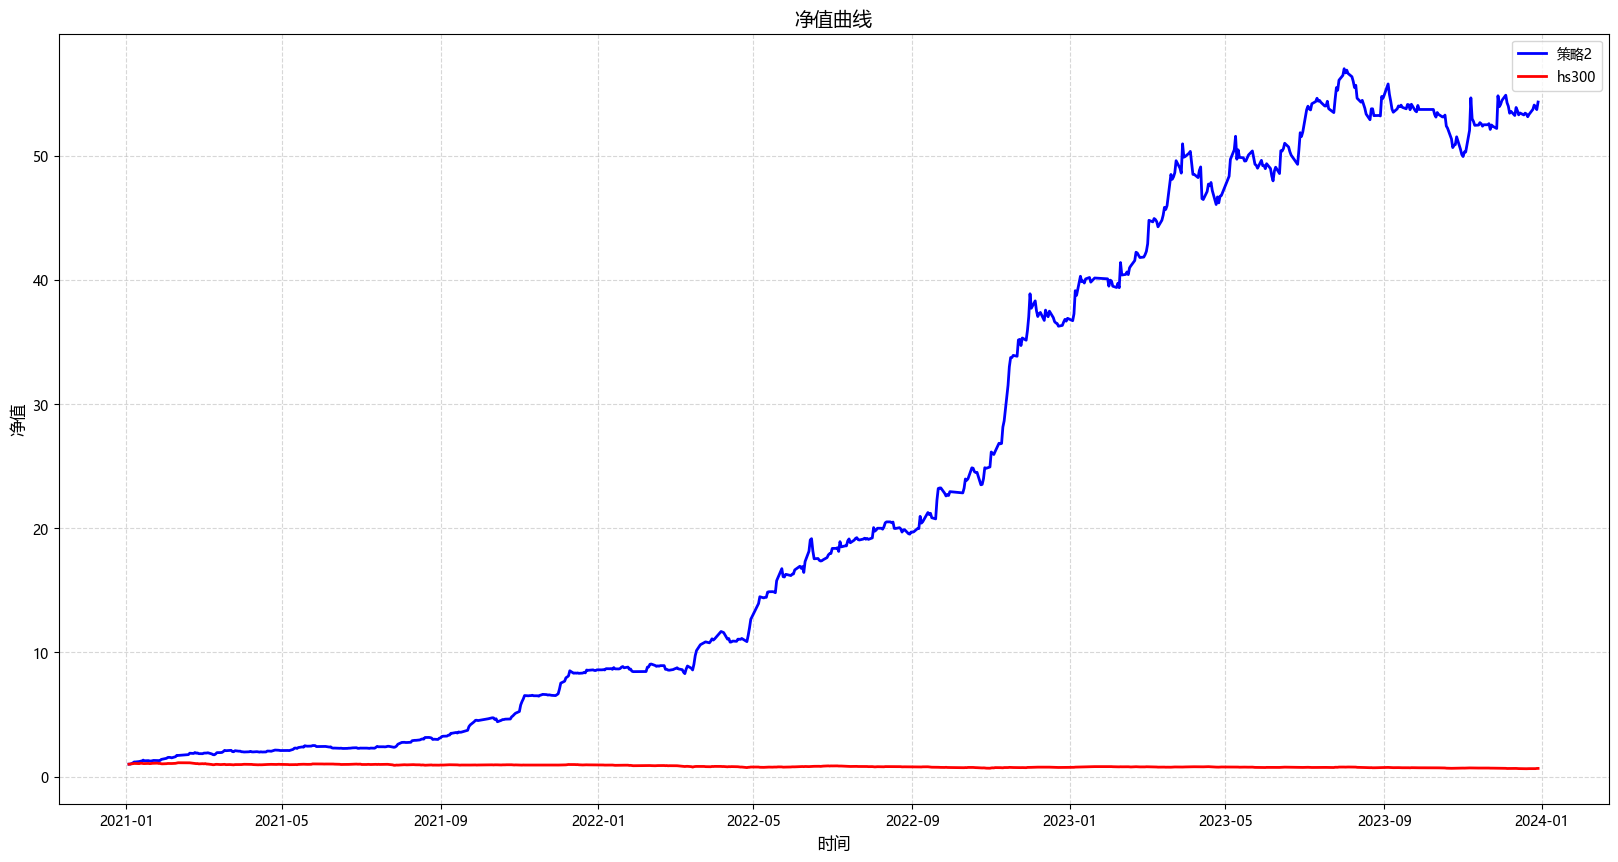

In [19]:
plot_value(df_hs300_c_s_p1and2_rate, '策略2')

### 3 购买预测值排序为1、2、3的股票各1/3

In [21]:
# 获取预测值第一的股票下一天的收益
df_hs300_c_s_p123_rate = df_hs300_c_s_p_merge_new[df_hs300_c_s_p_merge_new['pred'].shift(1) <= 3.0].sort_values(by = ['交易日期'],ascending=True)[['交易日期','涨跌幅（%）']]
df_hs300_c_s_p123_rate = pd.DataFrame(df_hs300_c_s_p123_rate.groupby('交易日期')['涨跌幅（%）'].mean() + 1)
df_hs300_c_s_p123_rate.columns = ['pred1收益率']
df_hs300_c_s_p123_rate = pd.merge(df_hs300_c_s_p123_rate, df_hs300_rate, on = ["交易日期"], how = "inner")
df_hs300_c_s_p123_rate['超额收益'] = df_hs300_c_s_p123_rate['pred1收益率'] - df_hs300_c_s_p123_rate['hs300收益率']

In [22]:
# 计算收益、回撤和夏普
cal_value(df_hs300_c_s_p123_rate)

超额收益: 24.9478
累计收益: 25.6070
最大回撤: 0.1109
夏普比率: 5.2443


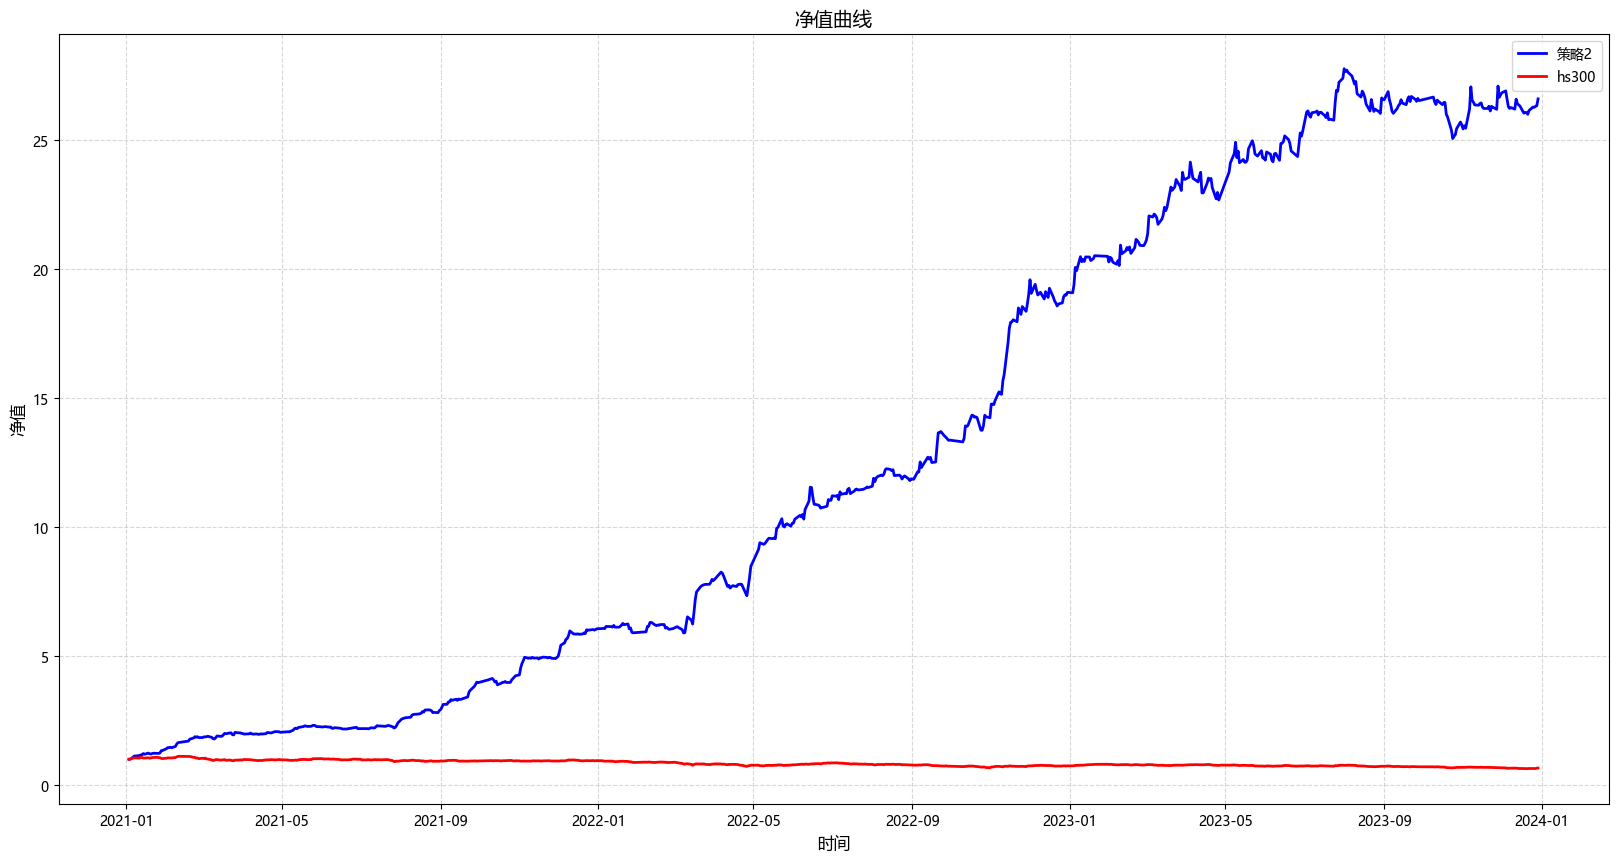

In [23]:
plot_value(df_hs300_c_s_p123_rate, '策略2')

### 4 购买预测值排序前5的股票各1/5

In [25]:
# 获取预测值第一的股票下一天的收益
df_hs300_c_s_p12345_rate = df_hs300_c_s_p_merge_new[df_hs300_c_s_p_merge_new['pred'].shift(1) <= 5.0].sort_values(by = ['交易日期'],ascending=True)[['交易日期','涨跌幅（%）']]
df_hs300_c_s_p12345_rate = pd.DataFrame(df_hs300_c_s_p12345_rate.groupby('交易日期')['涨跌幅（%）'].mean() + 1)
df_hs300_c_s_p12345_rate.columns = ['pred1收益率']
df_hs300_c_s_p12345_rate = pd.merge(df_hs300_c_s_p12345_rate, df_hs300_rate, on = ["交易日期"], how = "inner")
df_hs300_c_s_p12345_rate['超额收益'] = df_hs300_c_s_p12345_rate['pred1收益率'] - df_hs300_c_s_p12345_rate['hs300收益率']

In [26]:
# 计算收益、回撤和夏普
cal_value(df_hs300_c_s_p12345_rate)

超额收益: 6.9341
累计收益: 7.5932
最大回撤: 0.1232
夏普比率: 4.8073


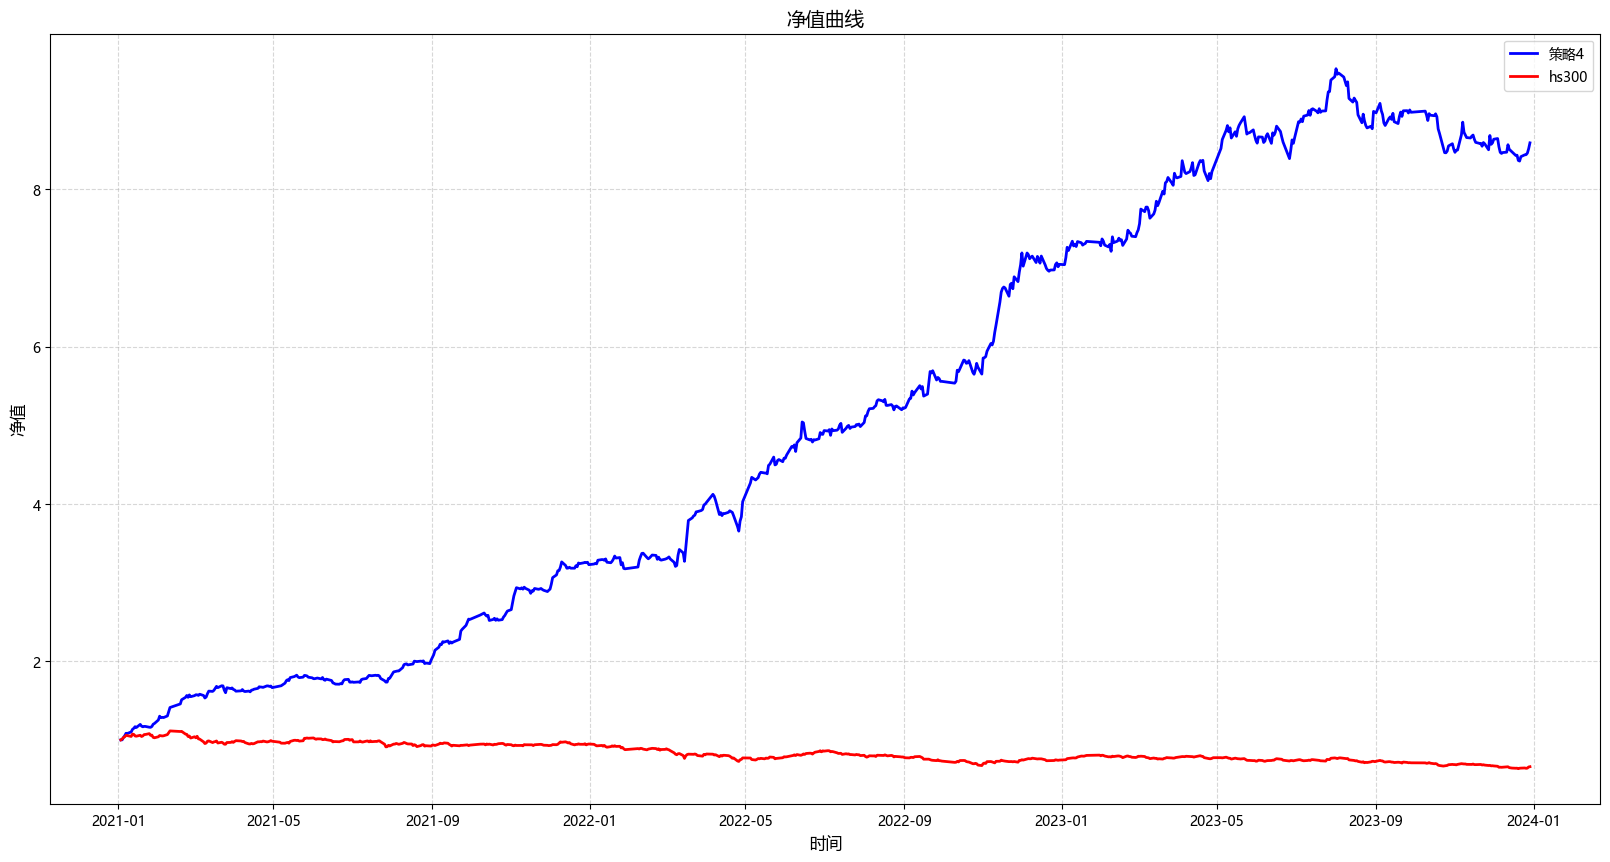

In [27]:
plot_value(df_hs300_c_s_p12345_rate, '策略4')

### 5 购买预测值排序前10的股票各1/10


In [29]:
# 获取预测值第一的股票下一天的收益
df_hs300_c_s_ptop10_rate = df_hs300_c_s_p_merge_new[df_hs300_c_s_p_merge_new['pred'].shift(1) <= 10.0].sort_values(by = ['交易日期'],ascending=True)[['交易日期','涨跌幅（%）']]
df_hs300_c_s_ptop10_rate = pd.DataFrame(df_hs300_c_s_ptop10_rate.groupby('交易日期')['涨跌幅（%）'].mean() + 1)
df_hs300_c_s_ptop10_rate.columns = ['pred1收益率']
df_hs300_c_s_ptop10_rate = pd.merge(df_hs300_c_s_ptop10_rate, df_hs300_rate, on = ["交易日期"], how = "inner")
df_hs300_c_s_ptop10_rate['超额收益'] = df_hs300_c_s_ptop10_rate['pred1收益率'] - df_hs300_c_s_ptop10_rate['hs300收益率']

In [30]:
# 计算收益、回撤和夏普
cal_value(df_hs300_c_s_ptop10_rate)

超额收益: 1.9216
累计收益: 2.5807
最大回撤: 0.1086
夏普比率: 4.1182


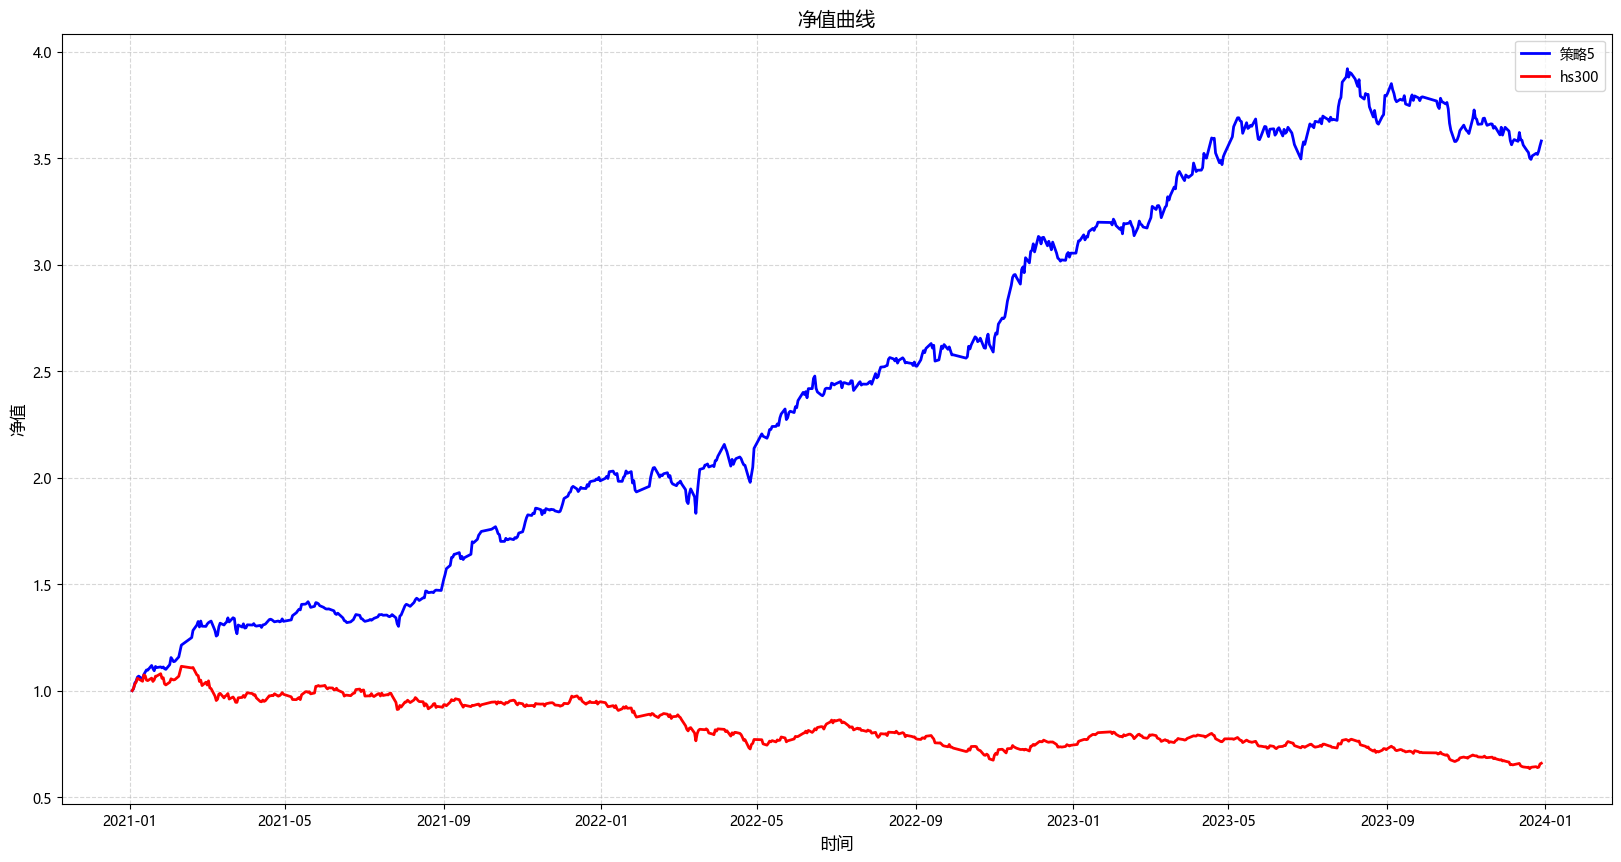

In [31]:
plot_value(df_hs300_c_s_ptop10_rate, '策略5')

#### 排除均值-方差体系中，历史波动较大的股票

In [33]:
# 筛选满足历史平均超额收益/历史超额收益方差和历史平均收益/历史收益方差均大于0.18的股票
df_hs300_c_s_history = df_hs300_c_s[df_hs300_c_s['交易日期'] < pd.to_datetime('2021-01-04')]
df_hs300_c_s_history_rate = pd.DataFrame(df_hs300_c_s_history.groupby('股票代码')['涨跌幅（%）'].mean())
df_hs300_c_s_history_rate.columns = ['历史平均收益']
df_hs300_c_s_history = pd.merge(df_hs300_c_s_history, df_hs300, on = "交易日期", how = "left")
df_hs300_c_s_history['超额收益'] = df_hs300_c_s_history['涨跌幅（%）'] - df_hs300_c_s_history['涨跌幅(%)']/100
df_hs300_c_s_history_excess_rate = pd.DataFrame(df_hs300_c_s_history.groupby('股票代码')['超额收益'].mean())
df_hs300_c_s_history_excess_rate.columns = ['历史平均超额收益']
df_hs300_c_s_history_excess_rate = pd.merge(df_hs300_c_s_history_excess_rate, df_hs300_c_s_history_rate, on = "股票代码", how = "inner")
df_hs300_c_s_history_std = pd.DataFrame(df_hs300_c_s_history.groupby('股票代码')['涨跌幅（%）'].std())
df_hs300_c_s_history_std.columns = ['历史收益方差']
df_hs300_c_s_history_excess_std = pd.DataFrame(df_hs300_c_s_history.groupby('股票代码')['超额收益'].std())
df_hs300_c_s_history_excess_std.columns = ['历史超额收益方差']
df_hs300_c_s_history_excess_rate = pd.merge(df_hs300_c_s_history_excess_rate, df_hs300_c_s_history_std, on = "股票代码", how = "inner")
df_hs300_c_s_history_excess_rate = pd.merge(df_hs300_c_s_history_excess_rate, df_hs300_c_s_history_excess_std, on = "股票代码", how = "inner")
df_hs300_c_s_history_excess_rate['历史平均超额收益/历史超额收益方差'] = df_hs300_c_s_history_excess_rate['历史平均超额收益']/df_hs300_c_s_history_excess_rate['历史超额收益方差']
df_hs300_c_s_history_excess_rate['历史平均收益/历史收益方差'] = df_hs300_c_s_history_excess_rate['历史平均收益']/df_hs300_c_s_history_excess_rate['历史收益方差']

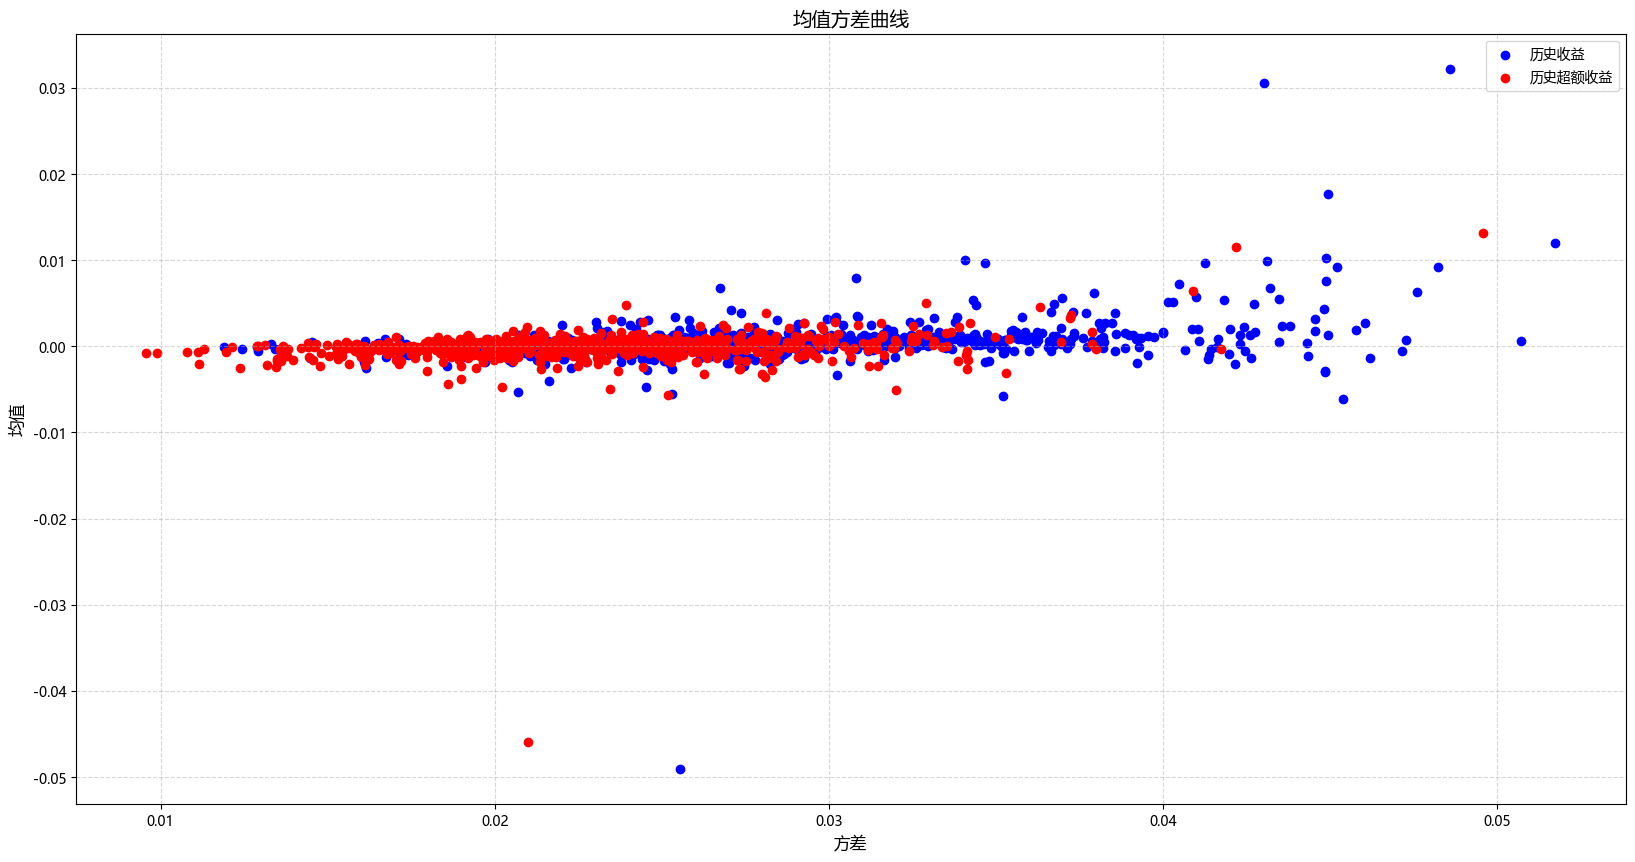

In [34]:
# 绘制曲线图
plt.figure(figsize=(20, 10))         # 设置图像大小
plt.scatter(df_hs300_c_s_history_excess_rate['历史收益方差'], df_hs300_c_s_history_excess_rate['历史平均收益'], label='历史收益', color='blue')
plt.scatter(df_hs300_c_s_history_excess_rate['历史超额收益方差'], df_hs300_c_s_history_excess_rate['历史平均超额收益'], label='历史超额收益', color='red')

# 添加标题和标签
plt.title('均值方差曲线', fontsize=14)
plt.xlabel('方差', fontsize=12)
plt.ylabel('均值', fontsize=12)

# 添加图例和网格
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 显示图像
plt.show()

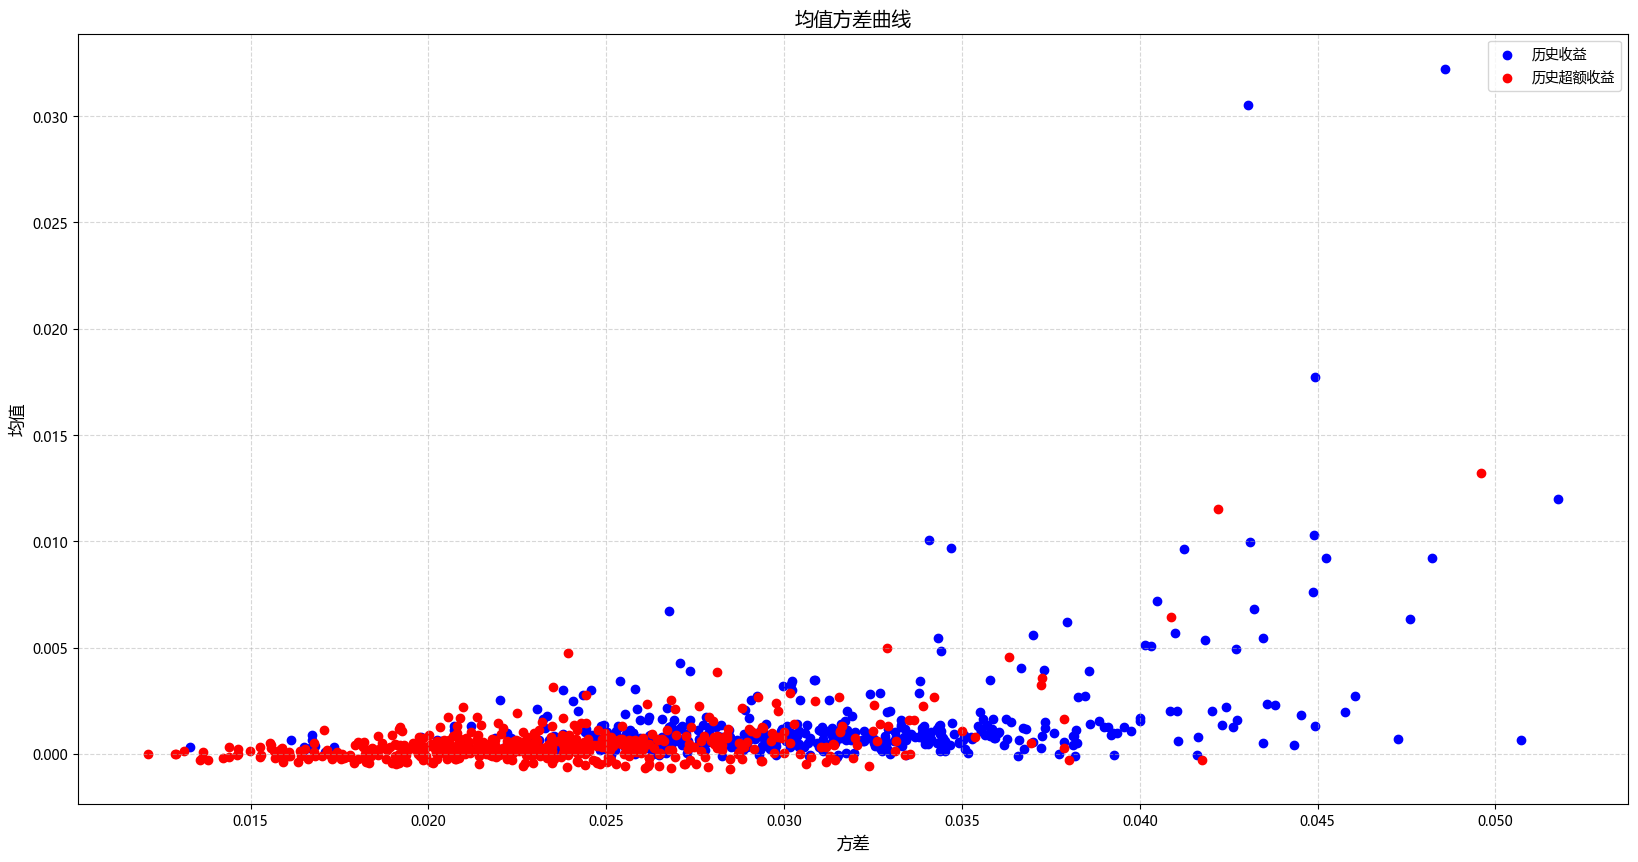

In [35]:
target_stock = df_hs300_c_s_history_excess_rate[(df_hs300_c_s_history_excess_rate['历史平均收益/历史收益方差'] >df_hs300_c_s_history_excess_rate['历史平均收益/历史收益方差'].describe()['25%']) & (df_hs300_c_s_history_excess_rate['历史平均超额收益/历史超额收益方差'] >df_hs300_c_s_history_excess_rate['历史平均超额收益/历史超额收益方差'].describe()['25%'])]
# 绘制曲线图
plt.figure(figsize=(20, 10))         # 设置图像大小
plt.scatter(target_stock['历史收益方差'], target_stock['历史平均收益'], label='历史收益', color='blue')
plt.scatter(target_stock['历史超额收益方差'], target_stock['历史平均超额收益'], label='历史超额收益', color='red')

# 添加标题和标签
plt.title('均值方差曲线', fontsize=14)
plt.xlabel('方差', fontsize=12)
plt.ylabel('均值', fontsize=12)

# 添加图例和网格
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# 显示图像
plt.show()

In [36]:
df_target_stock_info = df_hs300_c_s_p_merge_new[df_hs300_c_s_p_merge_new['股票代码'].isin(target_stock.index)]
df_target_stock_info['new_pred'] = df_target_stock_info.groupby('交易日期')['pred'].rank(ascending=True)

C:\Users\Shower\AppData\Local\Temp\ipykernel_21376\2815955436.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target_stock_info['new_pred'] = df_target_stock_info.groupby('交易日期')['pred'].rank(ascending=True)


### 筛选股票后

#### 1 全仓购买预测值排序为1的股票

In [39]:
# 先按股票代码排序，方便获取预测值第一的股票下一天的收益
df_target_stock_info = df_target_stock_info.sort_values(by = ['股票代码','交易日期'],ascending=True)

In [40]:
# 获取预测值第一的股票下一天的收益
df_hs300_c_s_p1_rate = df_target_stock_info[df_target_stock_info['new_pred'].shift(1) == 1.0].sort_values(by = ['交易日期'],ascending=True)[['交易日期','涨跌幅（%）']]
df_hs300_c_s_p1_rate['pred1收益率'] = df_hs300_c_s_p1_rate['涨跌幅（%）'] + 1

In [41]:
# 获取沪深300涨跌幅
df_hs300_rate = df_hs300[pd.to_datetime('2021-01-04') <= df_hs300["交易日期"]][['交易日期','涨跌幅(%)']]
df_hs300_rate['hs300收益率'] = df_hs300_rate['涨跌幅(%)']/100 + 1

In [42]:
# 计算选取的超额收益
df_hs300_c_s_p1_rate = pd.merge(df_hs300_c_s_p1_rate, df_hs300_rate, on = ["交易日期"], how = "inner")
df_hs300_c_s_p1_rate['超额收益'] = df_hs300_c_s_p1_rate['pred1收益率'] - df_hs300_c_s_p1_rate['hs300收益率']

In [43]:
# 计算收益、回撤和夏普
cal_value(df_hs300_c_s_p1_rate)

超额收益: 76.8817
累计收益: 77.5436
最大回撤: 0.1556
夏普比率: 4.1453


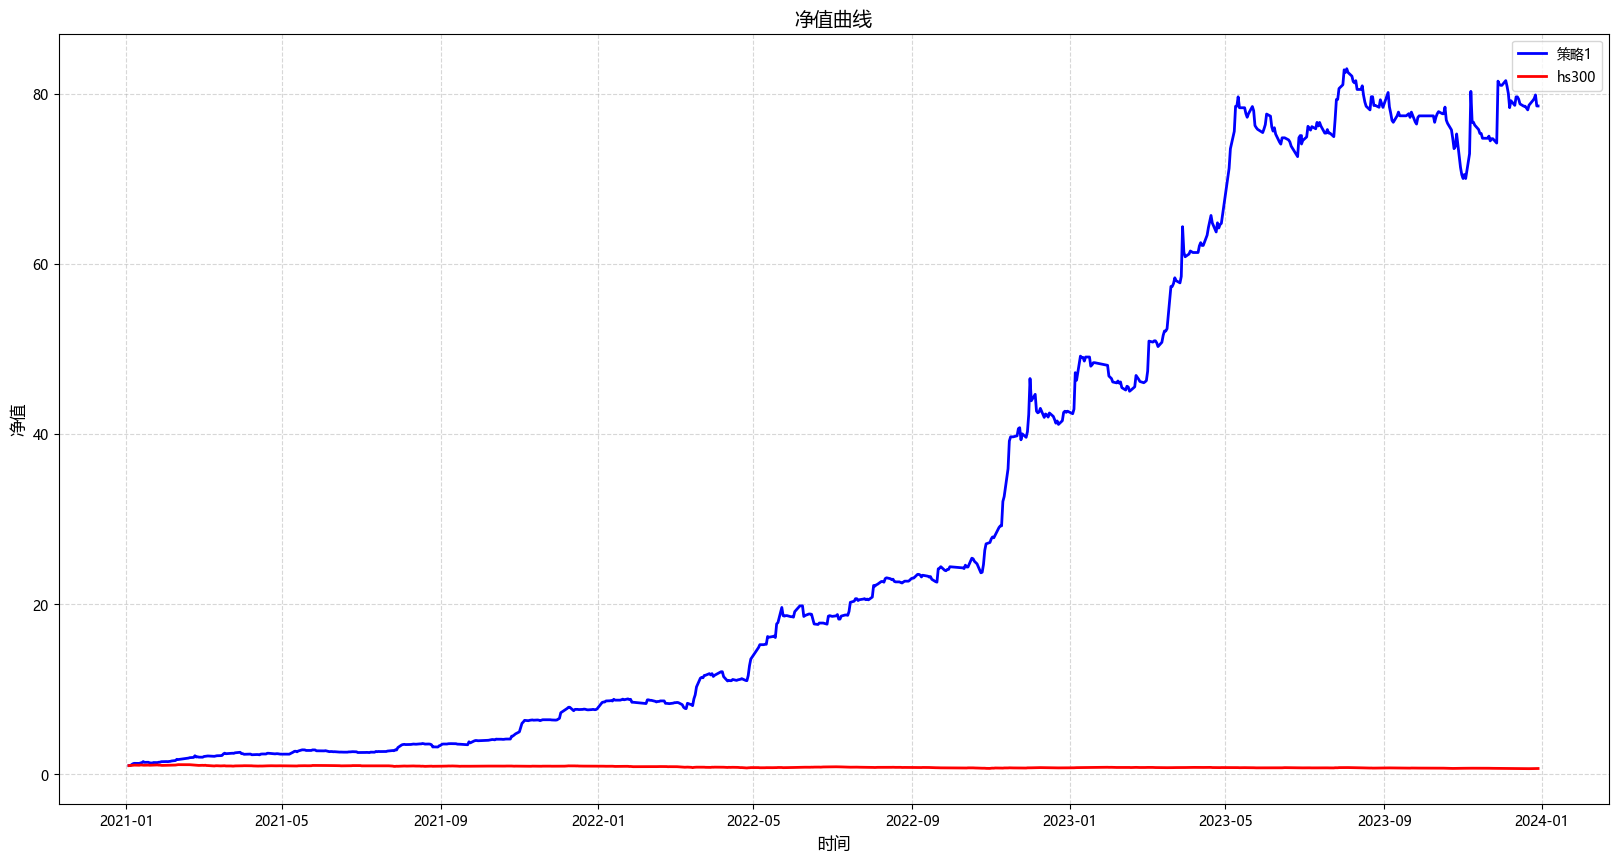

In [44]:
plot_value(df_hs300_c_s_p1_rate, '策略1')

### 2 购买预测值排序为1和2的股票各50%

In [46]:
# 获取预测值第一的股票下一天的收益
df_hs300_c_s_p1and2_rate = df_target_stock_info[df_target_stock_info['new_pred'].shift(1) <= 2.0].sort_values(by = ['交易日期'],ascending=True)[['交易日期','涨跌幅（%）']]
df_hs300_c_s_p1and2_rate = pd.DataFrame(df_hs300_c_s_p1and2_rate.groupby('交易日期')['涨跌幅（%）'].mean() + 1)
df_hs300_c_s_p1and2_rate.columns = ['pred1收益率']
df_hs300_c_s_p1and2_rate = pd.merge(df_hs300_c_s_p1and2_rate, df_hs300_rate, on = ["交易日期"], how = "inner")
df_hs300_c_s_p1and2_rate['超额收益'] = df_hs300_c_s_p1and2_rate['pred1收益率'] - df_hs300_c_s_p1and2_rate['hs300收益率']

In [47]:
# 计算收益、回撤和夏普
cal_value(df_hs300_c_s_p1and2_rate)

超额收益: 26.4975
累计收益: 27.1566
最大回撤: 0.1357
夏普比率: 4.5404


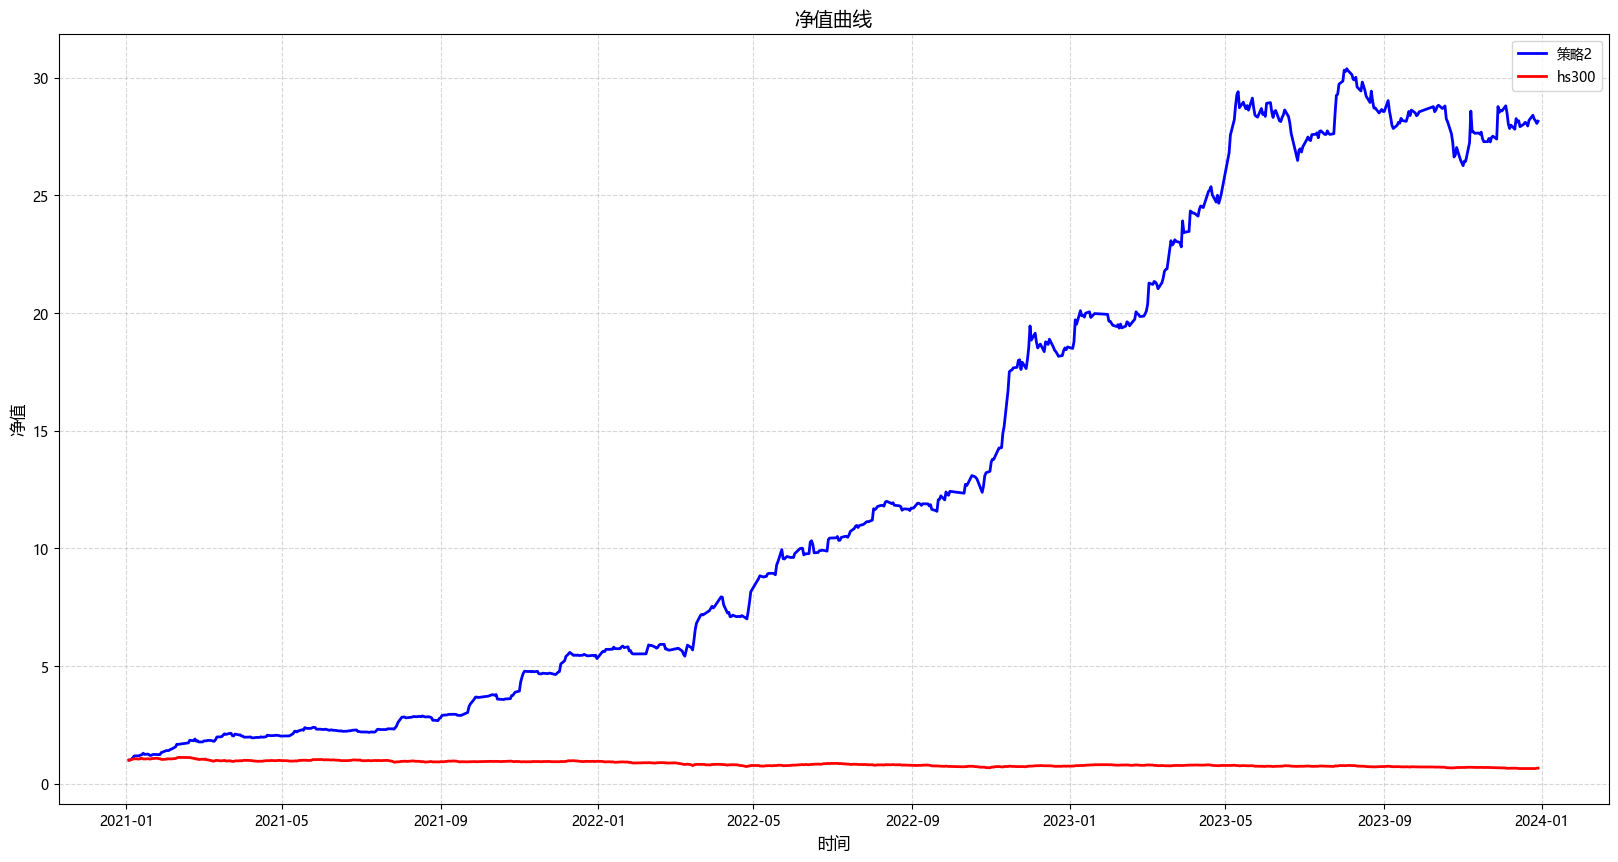

In [48]:
plot_value(df_hs300_c_s_p1and2_rate, '策略2')

### 3 购买预测值排序为1、2、3的股票各1/3

In [50]:
# 获取预测值第一的股票下一天的收益
df_hs300_c_s_p123_rate = df_target_stock_info[df_target_stock_info['new_pred'].shift(1) <= 3.0].sort_values(by = ['交易日期'],ascending=True)[['交易日期','涨跌幅（%）']]
df_hs300_c_s_p123_rate = pd.DataFrame(df_hs300_c_s_p123_rate.groupby('交易日期')['涨跌幅（%）'].mean() + 1)
df_hs300_c_s_p123_rate.columns = ['pred1收益率']
df_hs300_c_s_p123_rate = pd.merge(df_hs300_c_s_p123_rate, df_hs300_rate, on = ["交易日期"], how = "inner")
df_hs300_c_s_p123_rate['超额收益'] = df_hs300_c_s_p123_rate['pred1收益率'] - df_hs300_c_s_p123_rate['hs300收益率']

In [51]:
# 计算收益、回撤和夏普
cal_value(df_hs300_c_s_p123_rate)

超额收益: 10.1438
累计收益: 10.8029
最大回撤: 0.1300
夏普比率: 4.4153


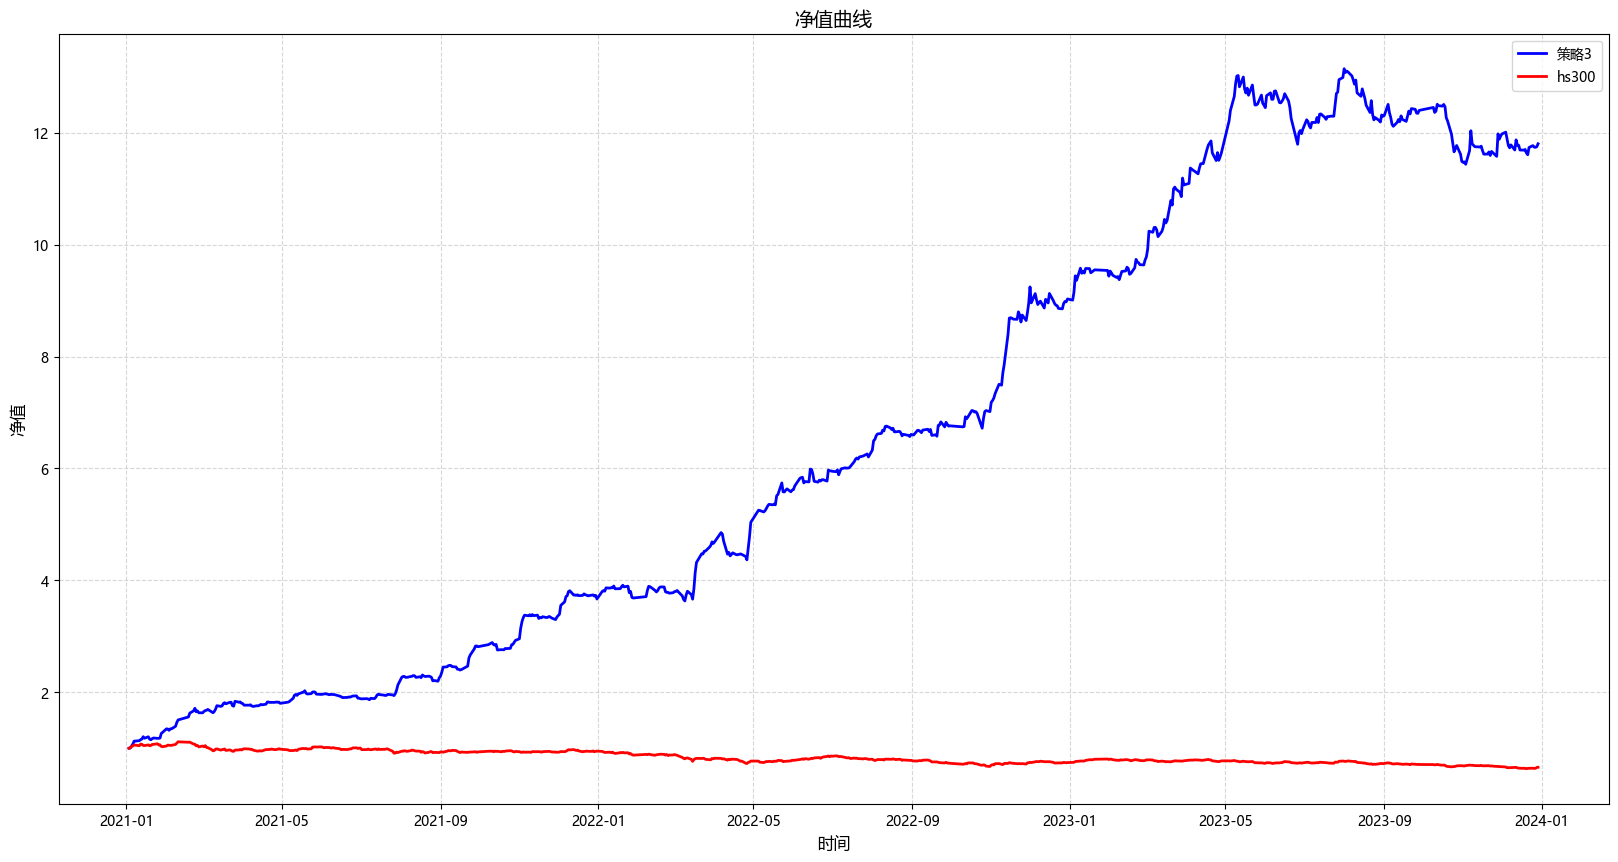

In [52]:
plot_value(df_hs300_c_s_p123_rate, '策略3')

### 4 购买预测值排序前5的股票各1/5

In [54]:
# 获取预测值第一的股票下一天的收益
df_hs300_c_s_p12345_rate = df_target_stock_info[df_target_stock_info['new_pred'].shift(1) <= 5.0].sort_values(by = ['交易日期'],ascending=True)[['交易日期','涨跌幅（%）']]
df_hs300_c_s_p12345_rate = pd.DataFrame(df_hs300_c_s_p12345_rate.groupby('交易日期')['涨跌幅（%）'].mean() + 1)
df_hs300_c_s_p12345_rate.columns = ['pred1收益率']
df_hs300_c_s_p12345_rate = pd.merge(df_hs300_c_s_p12345_rate, df_hs300_rate, on = ["交易日期"], how = "inner")
df_hs300_c_s_p12345_rate['超额收益'] = df_hs300_c_s_p12345_rate['pred1收益率'] - df_hs300_c_s_p12345_rate['hs300收益率']

In [55]:
# 计算收益、回撤和夏普
cal_value(df_hs300_c_s_p12345_rate)

超额收益: 3.3250
累计收益: 3.9841
最大回撤: 0.1497
夏普比率: 3.9804


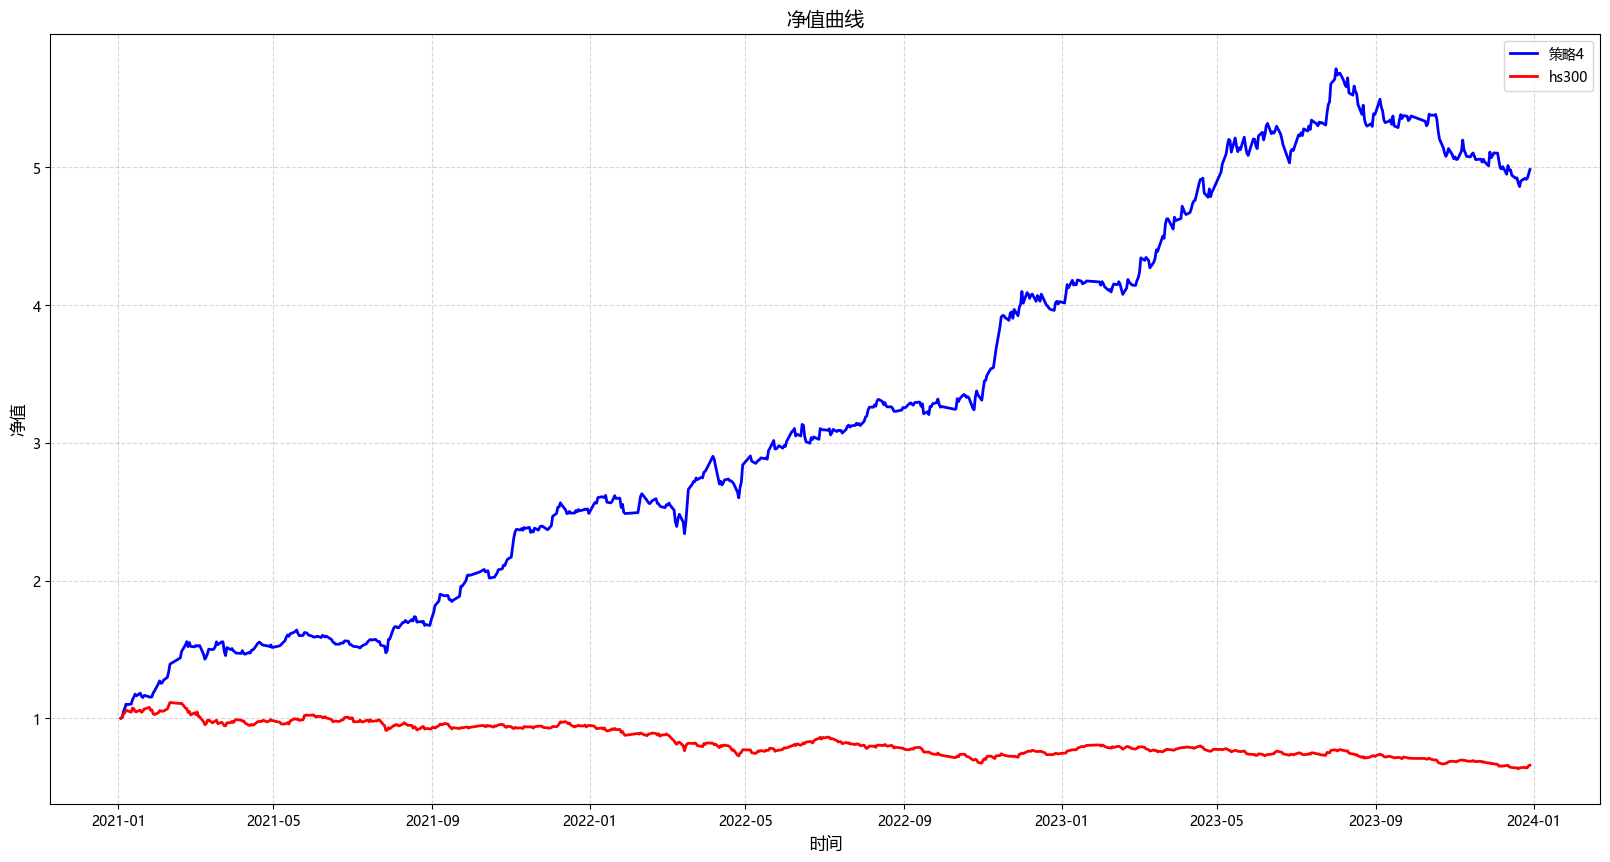

In [56]:
plot_value(df_hs300_c_s_p12345_rate, '策略4')

### 5 购买预测值排序前10的股票各1/10

In [58]:
# 获取预测值第一的股票下一天的收益
df_hs300_c_s_ptop10_rate = df_target_stock_info[df_target_stock_info['new_pred'].shift(1) <= 10.0].sort_values(by = ['交易日期'],ascending=True)[['交易日期','涨跌幅（%）']]
df_hs300_c_s_ptop10_rate = pd.DataFrame(df_hs300_c_s_ptop10_rate.groupby('交易日期')['涨跌幅（%）'].mean() + 1)
df_hs300_c_s_ptop10_rate.columns = ['pred1收益率']
df_hs300_c_s_ptop10_rate = pd.merge(df_hs300_c_s_ptop10_rate, df_hs300_rate, on = ["交易日期"], how = "inner")
df_hs300_c_s_ptop10_rate['超额收益'] = df_hs300_c_s_ptop10_rate['pred1收益率'] - df_hs300_c_s_ptop10_rate['hs300收益率']

In [59]:
# 计算收益、回撤和夏普
cal_value(df_hs300_c_s_ptop10_rate)

超额收益: 1.4268
累计收益: 2.0859
最大回撤: 0.1078
夏普比率: 3.8119


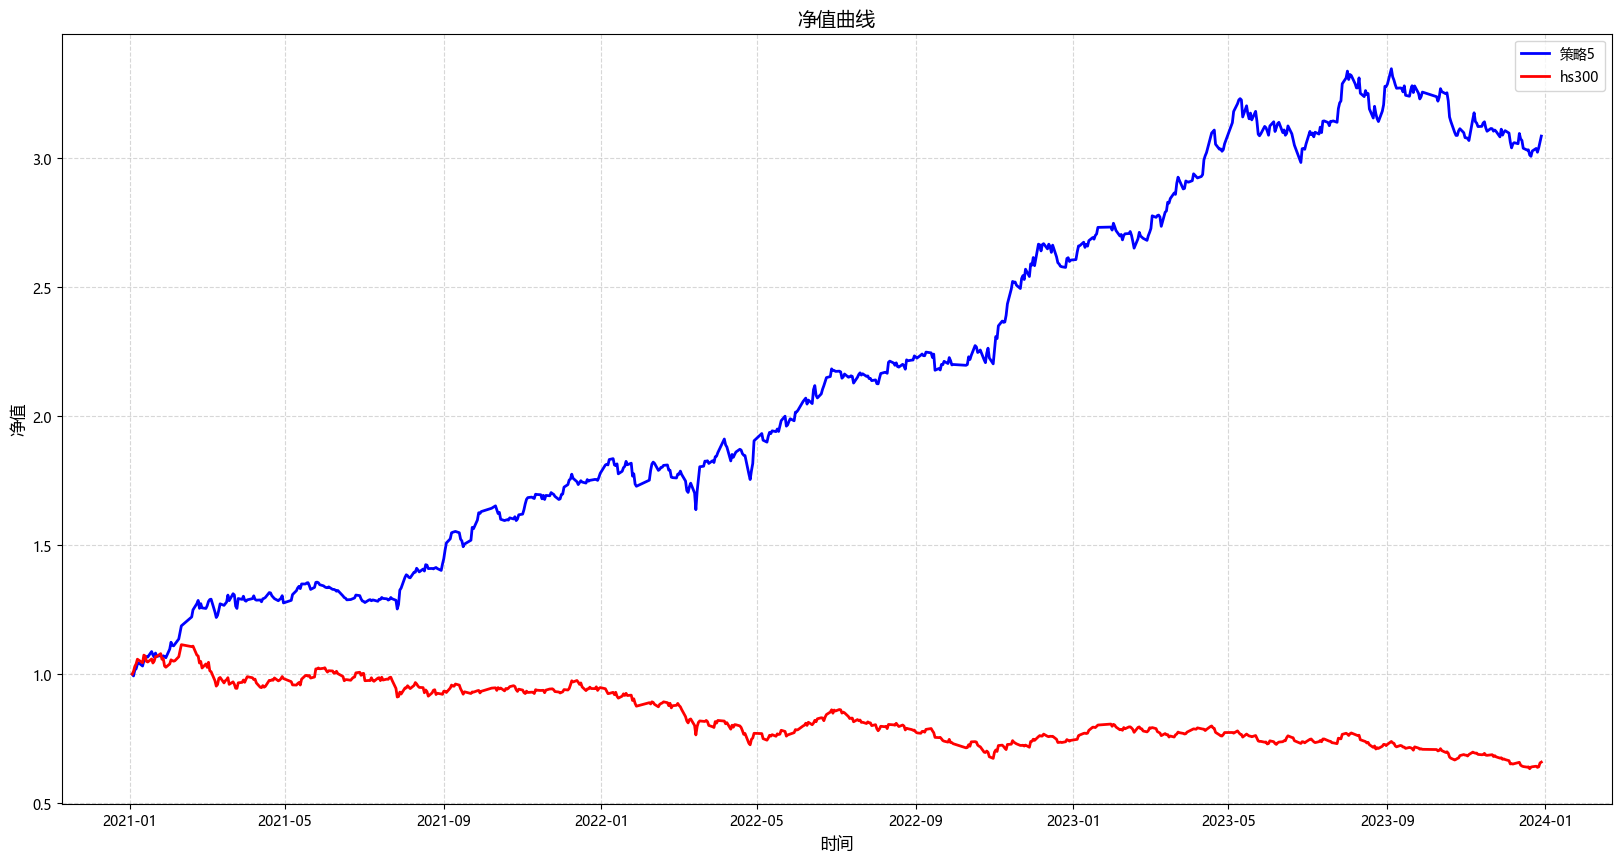

In [60]:
plot_value(df_hs300_c_s_ptop10_rate, '策略5')